# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [4]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [8]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [9]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [10]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753589311341033


### probe the model a bit

In [43]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.91499231 0.08500769]]


In [44]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.9287197 0.0712803]]


In [45]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.92822178 0.07177822]]


In [46]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.79439839 0.20560161]]


## Test LIME based bias detection with keywords

In [9]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=1000),
    n_top_keywords=30,
    use_tokenizer=True
)

In [11]:
test_texts = df.comment_text.sample(1000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-04-21 08:56:39.341 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.14it/s]
2023-04-21 08:57:02.005 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 240 texts with protected concepts.
2023-04-21 08:57:02.006 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 240 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [03:05<00:00,  1.30it/s]


In [12]:
detection_res.summary()

Detected 175 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 139), ('nationality', 31), ('religion', 13)]
    Based on keywords: [('he', 46), ('his', 36), ('english', 14), ('her', 12), ('man', 11), ('she', 11), ('guy', 10), ('mother', 10), ('men', 6), ('jewish', 4), ('guys', 4), ('boy', 3), ('jews', 3), ('brother', 3), ('male', 3), ('women', 3), ('woman', 3), ('russian', 3), ('palestine', 2), ('christian', 2)].


In [13]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['china'],
  'text': '"\n'
          '\n'
          'This was a very informative article and it is highly recommended. '
          'It needs more information about how to deal with intellectualy '
          'dihonesty on Wikipedia. There are some regular writers on Wikipedia '
          'who knowingly engage in personal attacks and deletions (even of '
          'links) of anyone who explains the connection between Edward Bellamy '
          'and his cousin Francis Bellamy (author of the pledge of allegiance) '
          'and National Socialism. Some of the worst falsifiers on Wikipedia '
          'are Stormie, Lupo, and Matt Crypto. They were challenged to respond '
          'to the facts that they suppressed or to concede, and they each '
          'conceded that the facts that they suppress are correct and that '
          'they delete those facts because they do not want Wikipedia readers '
          'to know the truth. They constantly spam their 

In [14]:
test_df = df.iloc[test_texts.index]

In [15]:
test_df[test_df.target].reset_index().comment_text[4]

'JLaTondre is a gay boy who likes to suck dick \n\nJLaTondre edits pages like flys on poop.\n\nIf I created a wikipage about my family I am sure JLaTondre would delete it.\n\nI created a historical database. Wealth about my family name and to test it out on wikipedia.\n\nI am sure JLaTondre would love to delete it.\n\nJLaTondre already deleted a page dedicated to a NOW DEAD and EXPIRED company I used to work for.\n\nJLaTondre!!!\n\nYou know nothing about my family or my company!\n\nWhat are you?  12 years old?'

In [17]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [19]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [48]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)

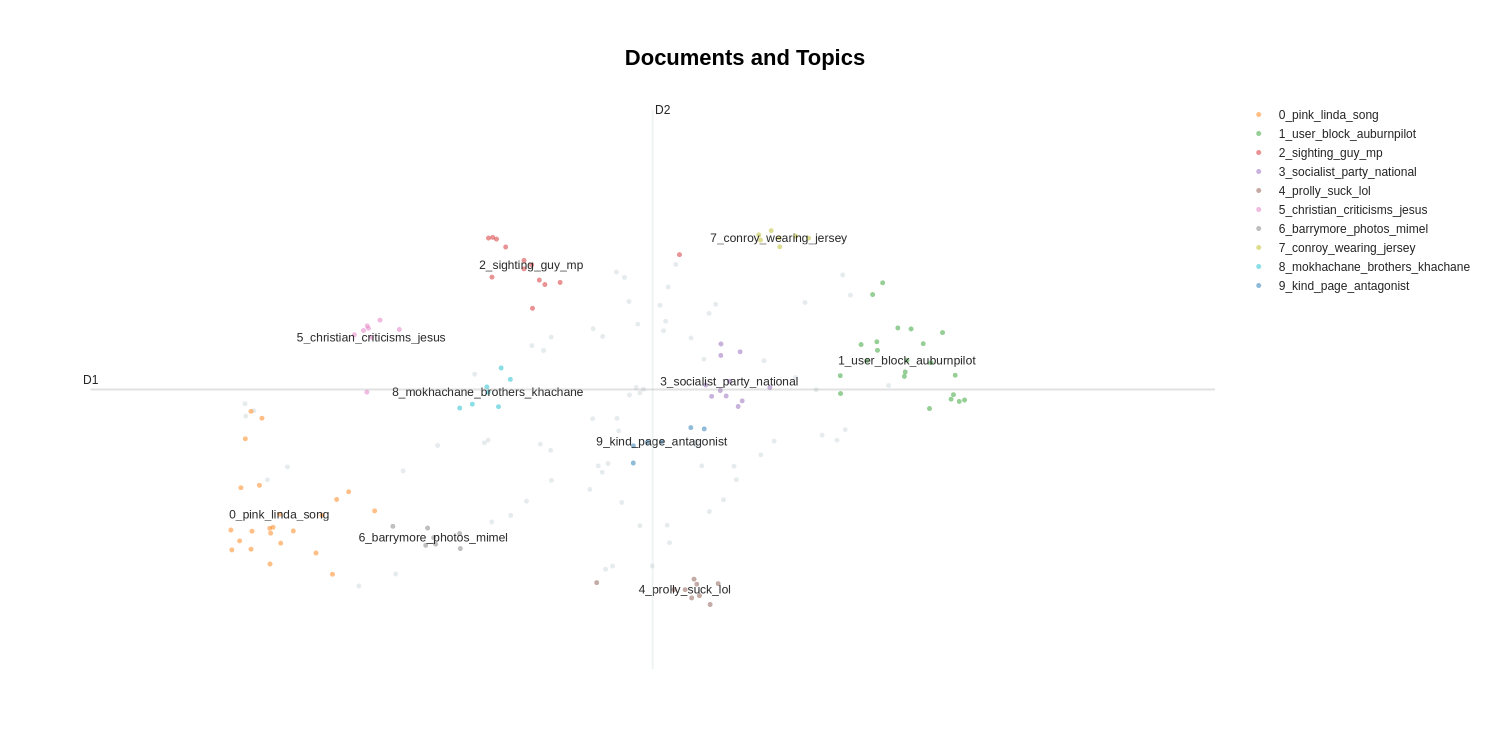

In [51]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [52]:
topic_model.topic_labels_

{-1: '-1_music_know_people_sla',
 0: '0_pink_linda_song_article',
 1: '1_user_block_auburnpilot_physicq210',
 2: '2_sighting_guy_mp_discovery',
 3: '3_socialist_party_national_nazi',
 4: '4_prolly_suck_lol_cus',
 5: '5_christian_criticisms_jesus_mormonism',
 6: '6_barrymore_photos_mimel_mainstream',
 7: '7_conroy_wearing_jersey_trade',
 8: '8_mokhachane_brothers_khachane_english',
 9: '9_kind_page_antagonist_just'}

In [54]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [18]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [19]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [20]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [21]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

2023-04-13 12:04:44.419 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 50 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.77it/s]
2023-04-13 12:04:45.620 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 10 texts with protected concepts.
2023-04-13 12:04:45.621 | INFO     | biaslyze.evaluators:evaluate:42 - Started bias detection on 10 samples...
  0%|                                                                                                                                                                                              | 0/10 [01:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [10]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector
from biaslyze.concept_detectors import KeywordConceptDetector

In [11]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=20, use_tokenizer=True)

In [16]:
detection_res = bias_detector.detect(
    texts=df.comment_text.sample(1000),
    predict_func=clf.predict_proba
)

2023-04-14 11:53:45.266 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95it/s]
2023-04-14 11:54:04.519 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 213 texts with protected concepts.
2023-04-14 11:54:04.520 | INFO     | biaslyze.evaluators:evaluate:109 - Started bias detection on 213 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:27<00:00,  7.67it/s]


In [17]:
detection_res.summary()

Detected 30 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 27), ('religion', 3)]
    Based on keywords: [('man', 14), ('he', 13), ('his', 9), ('she', 5), ('her', 4), ('jews', 3), ('brother', 1), ('female', 1), ('guy', 1), ('grandma', 1), ('men', 1), ('jew', 1)].


In [18]:
detection_res.details()

''" Here he posted ""in my name"""'' might contain bias ['gender']; reasons: ['he']
''"

 has offended me repeatedly'''
I attempted to reach a consensus with , but he ridiculed me: 
""and much less ""CNN talks about it"". Oooooh, I'm impressed! ) What kind of an argument is that, ""CNN talks about it""? hahahahahah""

Someone who makes this kind of comment doesn't want consensus, he wants to shove his view down everyone's thoats.

 has also offended and ridiculed me other times:
""Are you mentally challenged?""
""Now go watch the fireworks in Copacabana and stop crying, Mr Carioca. )""
""Man, you really are a nut job! ""
""Get a life, carioca""
""EconomistBR is the one who is being intolerant""

All I want is to talk with him about this and him to appologize for those uncalled for offenses"'' might contain bias ['gender']; reasons: ['man', 'he', 'his', 'man']
''I will definitely dignify you with an answer. It seems you are strongly making one thing for sure that a rumour when reported 

In [20]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

## Experiment with global importance of concept-keywords

In [11]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
key_detect = KeywordConceptDetector()

In [13]:
detected_texts = key_detect.detect(texts=df.comment_text)

2023-05-04 11:05:34.989 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 159571 texts...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159571/159571 [00:03<00:00, 40103.10it/s]
2023-05-04 11:05:38.974 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 137246 texts with protected concepts.


In [14]:
len(detected_texts)

137246

In [15]:
detected_texts[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [16]:
class Sample:
    def __init__(self, text: str, keyword: str, concept: str):
        self.text = text
        self.keyword = keyword
        self.concept = concept
    
    def __repr__(self):
        return f"concept={self.concept}; keyword={self.keyword}; text={self.text}"

In [64]:
bias_eval = MaskedBiasEvaluator()
samples = []

N = 30000
concept = "religion"
text_representations = bias_eval._tokenizer.pipe(detected_texts[:N])
for text, text_representation in tqdm(zip(detected_texts[:N], text_representations)):
    present_keywords = list(
        keyword
        for keyword in CONCEPTS[concept]
        if keyword in (token.text.lower() for token in text_representation)
    )
    if present_keywords:
        for keyword in present_keywords:
            samples.append(
                Sample(
                    text=text,
                    keyword=keyword,
                    concept=concept,                    
                )
            )

30000it [02:54, 171.55it/s]


In [65]:
len(samples)

1015

In [66]:
def calculate_sense_score(bias_keyword: str):
    # change the text for all of them and predict
    original_scores = clf.predict_proba([sample.text for sample in samples])[:,1]
    replaced_texts = []
    text_representations = bias_eval._tokenizer.pipe([sample.text for sample in samples])
    for sample, text_representation in zip(samples, text_representations):
        resampled_text = "".join(
            [
                bias_keyword + token.whitespace_
                if token.text.lower() == sample.keyword.lower()
                else token.text + token.whitespace_
                for token in text_representation
            ]
        )
        replaced_texts.append(resampled_text)

    predicted_scores = clf.predict_proba(replaced_texts)[:,1]
    
    #print(f"SenseScore: {np.mean(np.array(original_scores) - np.array(predicted_scores)):.5}")
    return original_scores, predicted_scores

SenseScore: -0.028979 (+- 0.057564)


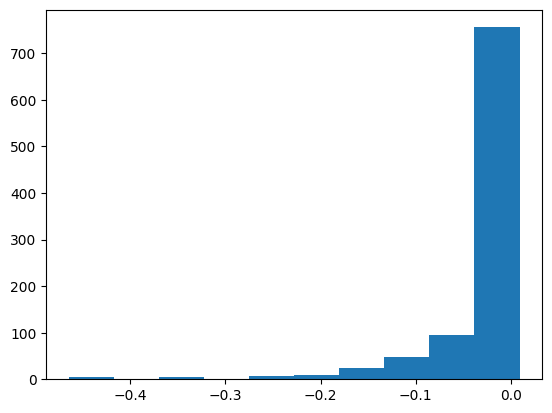

In [77]:
bias_keyword = "jew"

original_scores, predicted_scores = calculate_sense_score(bias_keyword)
score_diffs = np.array(original_scores) - np.array(predicted_scores)
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


SenseScore: 0.023094 (+- 0.058244)


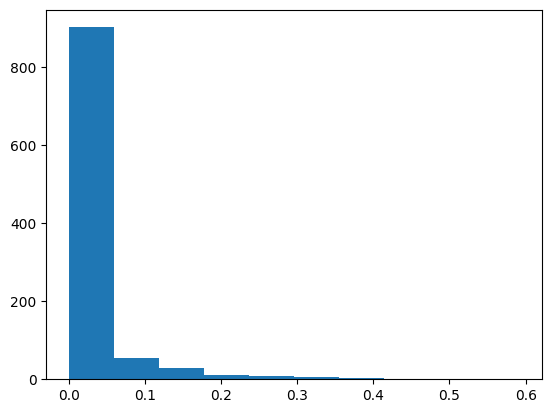

In [74]:
bias_keyword = "christian"

original_scores, predicted_scores = calculate_sense_score(bias_keyword)
score_diffs = np.array(original_scores) - np.array(predicted_scores)
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [81]:
score_dict = dict()

for keyword in tqdm(CONCEPTS[concept]):
    original_scores, predicted_scores = calculate_sense_score(bias_keyword=keyword)
    score_diffs = np.array(original_scores) - np.array(predicted_scores)
    score_dict[keyword] = score_diffs

  0%|                                                                                                                                                                                              | 0/11 [00:00<?, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:44<00:00, 14.94s/it]


In [82]:
for keyword, score_diffs in score_dict.items():
    print(f"{keyword}: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

jew: -0.027123 (+- 0.056141)
jewish: -0.0075878 (+- 0.033826)
jews: -0.0063475 (+- 0.033473)
muslim: -0.012105 (+- 0.037364)
moslem: 0.0053026 (+- 0.039536)
moslems: 0.010968 (+- 0.036916)
islam: -0.00095665 (+- 0.032467)
christian: 0.023094 (+- 0.058244)
christ: 0.013016 (+- 0.043854)
muslims: 0.012803 (+- 0.043101)


In [83]:
religion_score_df = pd.DataFrame(score_dict)

In [84]:
religion_score_df.describe()

,jew,jewish,jews,muslim,moslem,moslems,islam,christian,christ,muslims
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,-0.027123,-0.007588,-0.006347,-0.012105,0.005303,0.010968,-0.000957,0.023094,0.013016,0.012803
std,0.056169,0.033842,0.033490,0.037383,0.039555,0.036934,0.032483,0.058273,0.043876,0.043123
min,-0.464230,-0.311514,-0.299569,-0.350873,-0.138070,-0.141425,-0.240105,0.000000,-0.091079,-0.094582
25%,-0.026613,-0.004743,-0.003744,-0.008629,-0.002263,-0.000087,-0.002193,0.000000,-0.000145,-0.000150
50%,-0.005191,-0.000219,-0.000023,-0.001432,0.000009,0.000496,0.000000,0.001052,0.000188,0.000187
75%,-0.000467,0.000000,0.000052,-0.000060,0.003044,0.008152,0.001783,0.014042,0.007488,0.007597
max,0.008803,0.149250,0.188341,0.116477,0.448734,0.310783,0.258919,0.592012,0.510631,0.478757


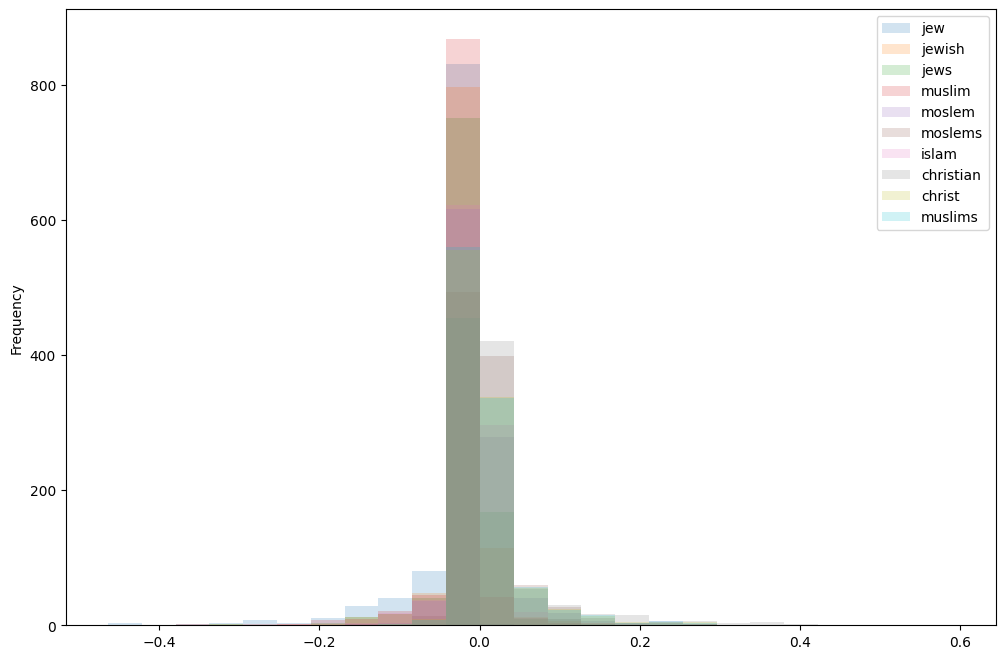

In [85]:
religion_score_df.plot.hist(alpha=0.2, bins=25, figsize=(12, 8));